<a href="https://colab.research.google.com/github/rahvlrawat/NYCTaxiFare/blob/main/NYC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgbm
import xgboost as xgb

# Downloads

In [2]:
os.system('pip install -q kaggle')
os.system('mkdir ~/.kaggle')
os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')



0

In [3]:
os.system('kaggle competitions download -c new-york-city-taxi-fare-prediction')

0

In [4]:
os.system('unzip  /content/train.csv.zip')

0

# Exploratory analysis,Cleaning and Feature Engineering

## Preliminary Analysis

First thing we do with a new dataset is to explore the data. This means investigating the number of features, their datatype, their meaning and some basics statistics.

This dataset is huge thus reading all data would require a lot of memory. Therefore I read a limited number of rows while exploring the data.

In [ ]:
train_df =  pd.read_csv('/content/train.csv', nrows = 2_000_000)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


Following insights can  be inferred from this small sample of our dataset:


1.   The minimal *fare_amount* is negative. As this does not seem to be realistic I will drop them from the dataset.
2.   Minimum and Maximum *longitude/lattitude coordinates* are way off . Will filter these out using bounding box for co-ordinates of the NYC.
3. Min value for *Passenger count* is 0 thus have to filter these rows where such values exist
4. Mean value for *Passenger count* is  around 1.68 but max value is 200+ which is not quite possible thus will need to see the distribution and filter out the outliers





Now for further insights will try EDA on complete dataset.As data is too big to be read and loaded directly so i used chunk-read   size of 5M along with converting some columns to smaller  datatype  so as  to use less space in memory.

In [ ]:
df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000# 5 million rows at one go. Or try 10 million
traintypes = {'fare_amount': 'float32',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'pickup_datetime': 'str',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())
for df_chunk in tqdm(pd.read_csv('/content/train.csv', usecols=cols, dtype=traintypes, chunksize=chunksize)):
        df_list.append(df_chunk) 
        del df_chunk
        

train_df = pd.concat(df_list)
del df_list



12it [01:46,  8.87s/it]


There are about total of 55Million+  rows in our dataset.

In [ ]:
len(train_df )

55423856

In [ ]:
train_df.shape

(55423856, 7)

In [ ]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


In [ ]:
train_df.isnull().sum().sort_index()/len(train_df)

dropoff_latitude     0.000007
dropoff_longitude    0.000007
fare_amount          0.000000
passenger_count      0.000000
pickup_datetime      0.000000
pickup_latitude      0.000000
pickup_longitude     0.000000
dtype: float64

There are some null values existing in data which we will drop.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float32
 1   pickup_datetime    object 
 2   pickup_longitude   float32
 3   pickup_latitude    float32
 4   dropoff_longitude  float32
 5   dropoff_latitude   float32
 6   passenger_count    uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 1.5+ GB


In order to utilize the pickup_datetime info will have to break down this data into its basic components year,month,day,hour,minute and seconds later.

In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


-New York city coordinates are 


longitude = -74.0063889
lattitude = 40.7141667

so accordingly will filter out the coordinates around these.

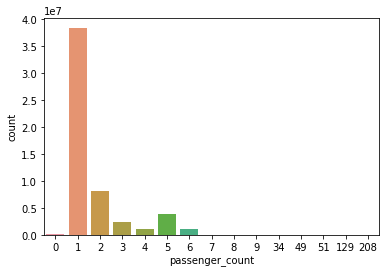

In [ ]:
sns.countplot(x='passenger_count',data=train_df)

From passenger count  plot its deduced that majority of our data lies for 6 passengers which is quite plausible for a cab and thus will drop all data pertaining to passenger count above that.

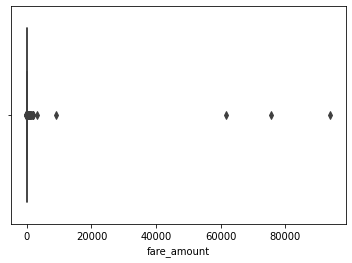

In [ ]:
sns.boxplot(x='fare_amount',data=train_df)

In [ ]:
train_df[train_df["fare_amount"]>20000]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18859340,61550.859375,2013-08-20 11:52:52 UTC,-73.967712,40.755966,-73.945572,40.747665,1
41032263,93963.359375,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2
41186018,75747.023438,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1


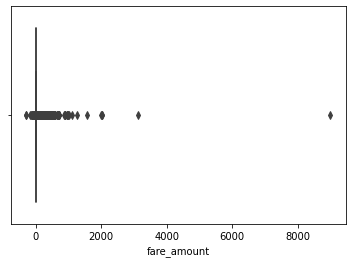

In [ ]:
sns.boxplot(x='fare_amount',data=train_df[train_df["fare_amount"]<20000])

In [ ]:
train_df[train_df["fare_amount"]>2000]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18592729,2010.900024,2010-03-21 10:03:32 UTC,-73.986267,40.774845,-73.971542,40.743950,1
18859340,61550.859375,2013-08-20 11:52:52 UTC,-73.967712,40.755966,-73.945572,40.747665,1
22703574,3130.300049,2015-03-09 15:28:56 UTC,-74.005417,40.664413,-74.005417,40.664413,1
30823273,2004.500000,2010-03-20 12:24:52 UTC,-73.963135,40.777855,-73.975433,40.782146,1
37879397,2023.699951,2010-03-21 14:43:02 UTC,-73.790054,40.647064,-73.917976,40.656940,1
39374511,9000.410156,2010-02-19 17:10:00 UTC,-73.993744,40.746105,-73.989807,40.738976,1
41032263,93963.359375,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2
41186018,75747.023438,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1


Will drop these rows with fare > 2000  as fare_amount is unbilievable large for these trips even though there seems to be no irregularity in other data and as can be seen from plots points beyond these are outliers anyways as majority data lies below 2000.

In [ ]:
len(train_df)

55423856

## Feature Engineering

In [5]:
jfk = (-73.7781, 40.6413)
ewr = (-74.1745, 40.6895)
lgr = (-73.8740, 40.7769)
tsq =(-74.1745, 40.6895)
met = (-73.9632,40.7794)


Taking a cab around some areas in city  is quiet expensive than others and thus i have picked up some major Airports/Terminals which are near and in the city.

In [6]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# Returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))   # 2*R*asin...

We will use haversine formula in order to calculate distance between the co-ordinates.

In [7]:
# list to hold the batch dataframe
chunksize = 1_000_000# 5 million rows at one go. Or try 10 million
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())


In [8]:
def processed_data(unprocessed_file_path):
  df_list = [] 
  count=0
  for df_chunk in tqdm(pd.read_csv(unprocessed_file_path, usecols=cols, dtype=traintypes, chunksize=chunksize,parse_dates=['pickup_datetime'])):
        df_chunk=df_chunk[df_chunk["fare_amount"].between(1, 2000, inclusive = True) ]
        df_chunk=df_chunk[df_chunk["passenger_count"].between(1, 6, inclusive = True) ]
        
        df_chunk=df_chunk.dropna(how = 'any', axis = 'rows')

        df_chunk=df_chunk[df_chunk['dropoff_longitude'].between(-75,-72, inclusive = True)]
        df_chunk=df_chunk[df_chunk['pickup_longitude'].between(-75, -72, inclusive = True)]
        df_chunk=df_chunk[df_chunk['pickup_latitude'].between(40, 42, inclusive = True)]
        df_chunk=df_chunk[df_chunk['dropoff_latitude'].between(40,42, inclusive = True)]

        df_chunk['diff_lat'] = ( df_chunk['dropoff_latitude'] - df_chunk['pickup_latitude']).abs()
        df_chunk['diff_long'] = (df_chunk['dropoff_longitude'] - df_chunk['pickup_longitude']).abs()

        df_chunk["geodesic"]=df_chunk.apply(lambda x: geopy.distance.geodesic((x.pickup_latitude,x.pickup_longitude),(x.dropoff_latitude,x.dropoff_longitude)), axis=1).astype(str).str[:-3].astype('float32')
        df_chunk=df_chunk[df_chunk["geodesic"]>=1]
        
        df_chunk['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_tsq'] = distance(tsq[1], tsq[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_tsq'] = distance(tsq[1], tsq[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_met'] = distance(met[1], met[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_met'] = distance(met[1], met[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')

        df_chunk[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]=df_chunk[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']].astype('float32')
        
        
        df_chunk['day']=(df_chunk['pickup_datetime'].dt.weekday).astype('uint8')
        df_chunk['month']=(df_chunk['pickup_datetime'].dt.month).astype('uint8')
        df_chunk['year']=df_chunk['pickup_datetime'].dt.year.astype('uint32')
        
        df_chunk['time']=df_chunk['pickup_datetime'].dt.time
        df_chunk[['hh','mm','ss']] = df_chunk['time'].astype(str).str.split(':', expand=True).astype(int)
        df_chunk=df_chunk.drop(["time","pickup_datetime"],axis=1)

        
        df_chunk['hh']=df_chunk['hh'].astype('uint8')
        df_chunk['mm']=df_chunk['mm'].astype('uint8')
        df_chunk['ss']=df_chunk['ss'].astype('uint8')

        
        df_list.append(df_chunk) 
        del df_chunk

        
        if(count==30):
          break
        else:
          count+=1  
        
  
  train_df = pd.concat(df_list)
  del df_list
  return train_df


In [ ]:
train_df = processed_data('train.csv')

20it [2:02:28, 367.53s/it]

First i will remove all duplicates from our data and then  sample this data due to memory limitations and save that sampled data for future use.

In [ ]:
train_df[train_df.duplicated(keep=False)]

In [ ]:
train_df.drop_duplicates(keep=False,inplace=True)

Some duplicate data also exists which we will  filter out.

In [ ]:
train_df.to_csv('/content/drive/MyDrive/NYC/mod_traincsv.csv',index=False)
train_df.reset_index().to_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')


In [ ]:
print("Done")

#### Further processing and inferences

In [ ]:
train_df=pd.read_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')


In [ ]:
train_df.set_index("index", inplace = True)

In [ ]:
train_df.shape

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

As we are using float16 dtype that's why getting NaN mean for some columns let's convert the dtype for these columns.

In [ ]:
train_df.columns

In [ ]:
cols=['geodesic',
       'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
       'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
       'pickup_distance_to_lgr', 'dropoff_distance_to_lgr',
       'pickup_distance_to_tsq', 'dropoff_distance_to_tsq',
       'pickup_distance_to_met', 'dropoff_distance_to_met']

In [ ]:
train_df[cols]=train_df[cols].astype('float32')

In [ ]:
train_df.describe()

Text(0, 0.5, 'Fare')

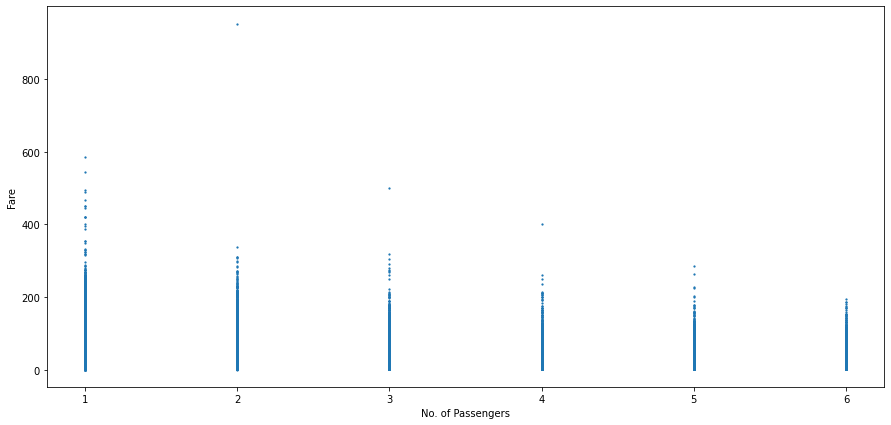

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

Above graph indicates that  single passengers are the most frequent travellers, and the highest fare also seems to come from cabs which carry just 1 passenger.

Text(0, 0.5, 'Fare')

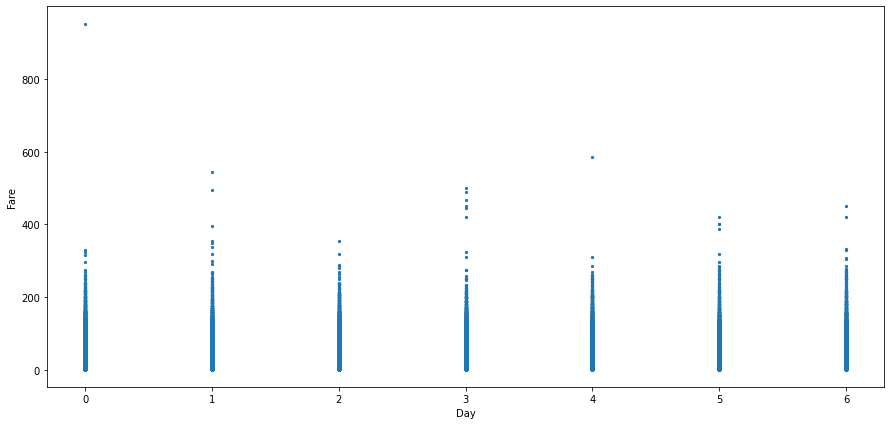

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['day'], y=train_df['fare_amount'], s=5)
plt.xlabel('Day')
plt.ylabel('Fare')

from above graph Fare  is comparatively  higher on  Sunday.

Text(0, 0.5, 'Fare')

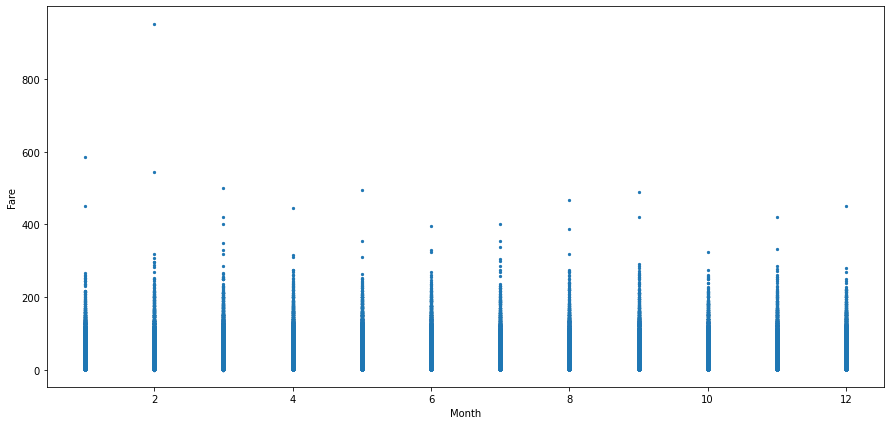

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['month'], y=train_df['fare_amount'], s=5)
plt.xlabel('Month')
plt.ylabel('Fare')

From above graph no particular pattern among these emerges except that recorded fare is quite low for January and December as compared to other months.

Text(0, 0.5, 'Fare')

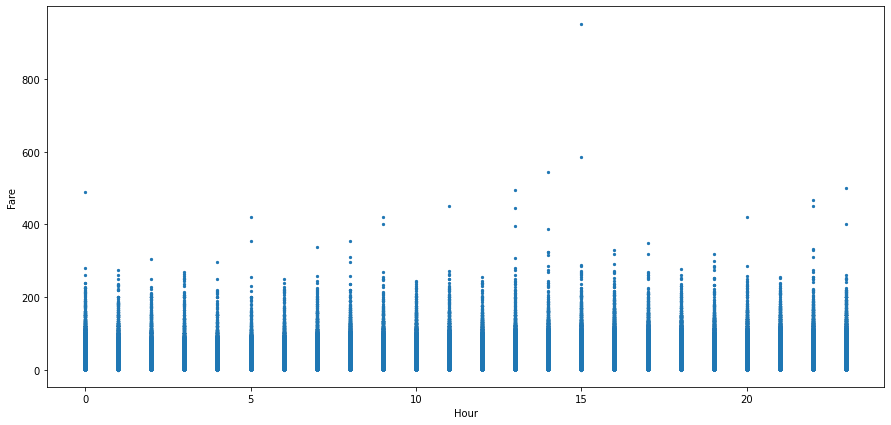

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_df['hh'], y=train_df['fare_amount'], s=5)
plt.xlabel('Hour')
plt.ylabel('Fare')

In [ ]:
train_df.sort_values(['geodesic','fare_amount'], ascending=False)

,fare_amount,passenger_count,diff_lat,diff_long,geodesic,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,pickup_distance_to_tsq,dropoff_distance_to_tsq,pickup_distance_to_met,dropoff_distance_to_met,day,month,year,hh,mm,ss
index,,,,,,,,,,,,,,,,,,,,,
17751102,8.5,2,0.696815,2.113548,195.375,87.415489,34.126694,107.729042,13.428939,96.239128,27.838921,107.729042,13.428939,100.403580,23.174129,6,6,2010,4,34,0
14229824,8.9,5,0.581558,1.969658,179.125,99.543098,11.659762,120.283432,10.616741,107.684731,6.652132,120.283432,10.616741,112.044075,4.219329,4,1,2009,2,32,0
14360243,9.0,1,0.725048,1.832603,175.250,96.012314,12.804369,116.322525,10.993978,104.808784,5.858243,116.322525,10.993978,108.985870,2.377357,6,9,2013,17,22,31
31417953,3.7,1,0.072586,2.082512,174.750,96.629478,44.225231,114.257469,34.920227,97.405411,33.602566,114.257469,34.920227,101.718727,31.312586,4,9,2010,9,6,31
9363026,7.5,1,0.684410,1.863632,174.000,13.214177,102.517868,11.003263,118.934494,5.884872,102.168045,11.003263,118.934494,2.035568,106.265953,1,2,2014,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29325539,3.3,1,0.008080,0.005241,1.000,12.803222,12.662766,12.127374,11.654166,4.798774,5.209507,12.127374,11.654166,1.202835,1.785233,3,12,2009,16,23,46
29692819,3.3,5,0.008965,0.001137,1.000,13.490068,13.733765,9.249315,9.515272,7.628980,7.337739,9.249315,9.515272,4.034672,3.502423,0,9,2010,14,28,0
17270481,3.0,1,0.007317,0.006905,1.000,13.599114,13.079818,8.333427,8.600915,8.718868,8.676017,8.333427,8.600915,5.338222,5.594294,2,10,2012,21,44,32


In [ ]:
bins_0 = train_df.loc[(train_df['geodesic'] == 0), ['geodesic']]
bins_1 = train_df.loc[(train_df['geodesic'] > 0) & (train_df['geodesic'] <= 10),['geodesic']]
bins_2 = train_df.loc[(train_df['geodesic'] > 10) & (train_df['geodesic'] <= 50),['geodesic']]
bins_3 = train_df.loc[(train_df['geodesic'] > 50) & (train_df['geodesic'] <= 100),['geodesic']]
bins_4 = train_df.loc[(train_df['geodesic'] > 100) & (train_df['geodesic'] <= 200),['geodesic']]
bins_5 = train_df.loc[(train_df['geodesic'] > 200) & (train_df['geodesic'] <= 300),['geodesic']]
bins_6 = train_df.loc[(train_df['geodesic'] > 300),['geodesic']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['geodesic', 'bins'], dtype='object')

Text(0, 0.5, 'Frequency')

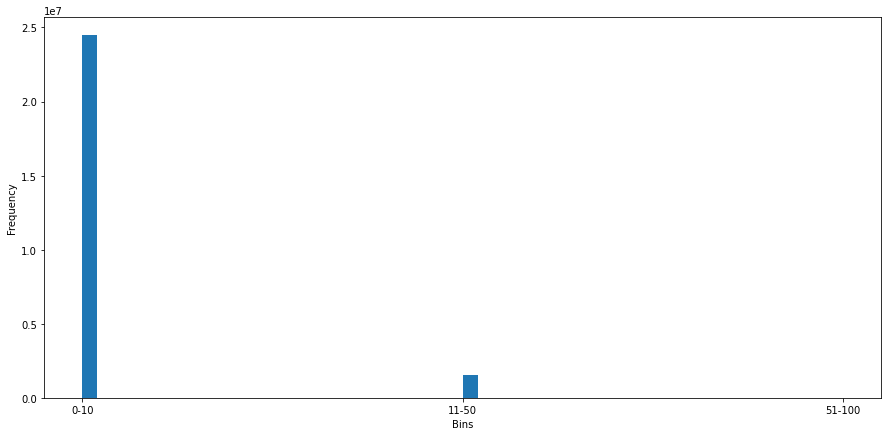

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(dist_bins['bins'], bins=50)
plt.xlabel('Bins')
plt.ylabel('Frequency')

In [ ]:
Counter(dist_bins['bins'])

Counter({'0-10': 24466626, '11-50': 1568642, '51-100': 4650})

Since the distance 51-100 Kms is quite large for a cab in NYC and has quite less corresponding data rows too we can drop this data.

In [ ]:
train_df=train_df[train_df['geodesic']<100]

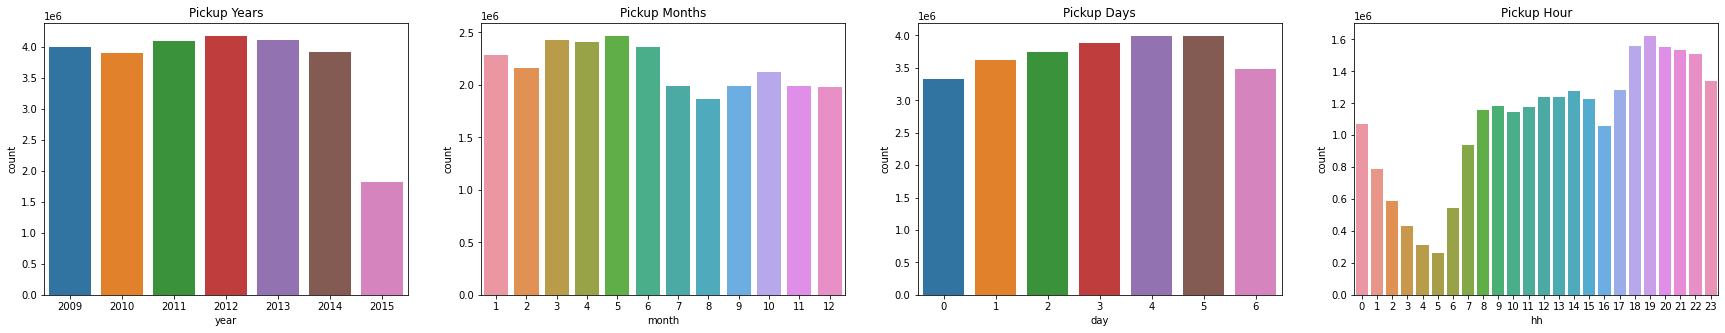

In [ ]:
figure,(ax1,ax2,ax3,ax4)=plt.subplots(ncols=4,figsize=(30,5))
ax1.set_title('Pickup Years')
ax=sns.countplot(x="year",data=train_df,ax=ax1)
ax2.set_title('Pickup Months')
ax=sns.countplot(x="month",data=train_df,ax=ax2)
ax3.set_title('Pickup Days')
ax=sns.countplot(x="day",data=train_df,ax=ax3)
ax4.set_title('Pickup Hour')
ax=sns.countplot(x="hh",data=train_df,ax=ax4)



From above graphs following observations can be made:


1.   Over the year total pickups have more or less remains the same but we can see very low value for year 2015 which is  due to the data not being for the complete year in case of 2015.

2.   As the year progressed the total pickups have gone down a bit month to month basis after initial high of first six months

3. Most pickups are made in weekdays compared to weekends

4. Most pickups are made 6 PM -11 PM 



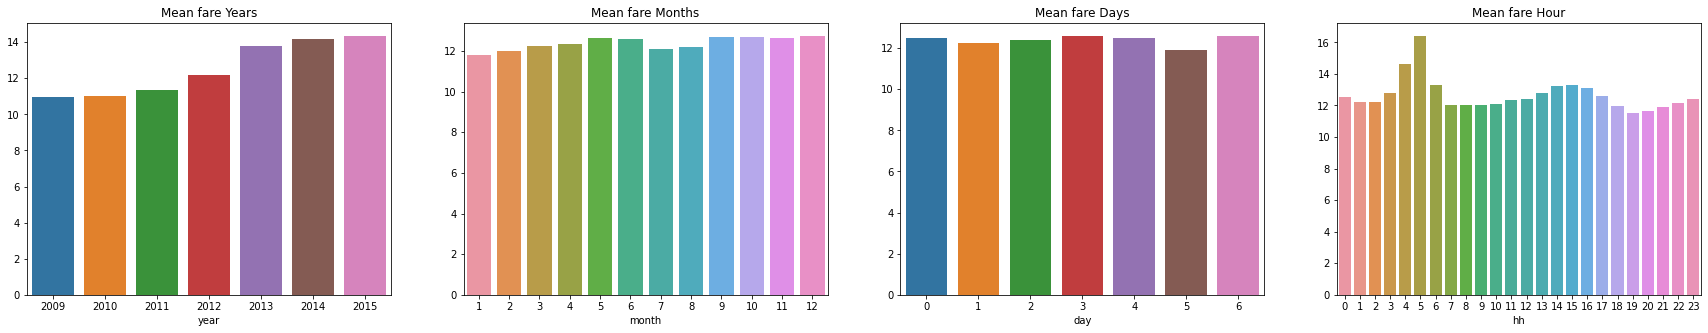

In [ ]:
figure,(ax1,ax2,ax3,ax4)=plt.subplots(ncols=4,figsize=(30,5))
ax1.set_title('Mean fare Years')
fair_yearmean=train_df.groupby('year')["fare_amount"].mean()
ax=sns.barplot(fair_yearmean.index,fair_yearmean.values,ax=ax1)

ax2.set_title('Mean fare Months')
fair_monthmean=train_df.groupby('month')["fare_amount"].mean()
ax=sns.barplot(fair_monthmean.index,fair_monthmean.values,ax=ax2)

ax3.set_title('Mean fare Days')
fair_daymean=train_df.groupby('day')["fare_amount"].mean()
ax=sns.barplot(fair_daymean.index,fair_daymean.values,ax=ax3)

ax4.set_title('Mean fare Hour')
fair_hourmean=train_df.groupby('hh')["fare_amount"].mean()
ax=sns.barplot(fair_hourmean.index,fair_hourmean.values,ax=ax4)



From above graphs following observations can be made:

1.   Over the years mean fare has increased in a progressive manner
2.   Over the months more or less mean fare has remained almost same with little variation for some months here and there
3. Mean fare remains similar for all days of the week with a little variation 
4. Mean fare is high for 4 AM -6 AM as opposed to other hours of the day 




In [ ]:
train_df.reset_index().to_csv('/content/drive/MyDrive/NYC/mod_traincsv.csv',index=False)

In [ ]:
train_df.reset_index().to_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')

#Training/Validation sets

In [ ]:
train_df=pd.read_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')
train_df.set_index("index", inplace = True)

In [ ]:
train=train_df.sample(10_000_000)


In [ ]:
train=train[train["year"]<2013]
valid=train[train["year"]>=2013]

In [ ]:
# X_train,y_train= train.drop('fare_amount', axis = 1),train['fare_amount']
# X_test,y_test= valid.drop('fare_amount', axis = 1),valid['fare_amount']

In [ ]:
train

,fare_amount,passenger_count,diff_lat,diff_long,geodesic,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,pickup_distance_to_tsq,dropoff_distance_to_tsq,pickup_distance_to_met,dropoff_distance_to_met,day,month,year,hh,mm,ss
index,,,,,,,,,,,,,,,,,,,,,
28934275,31.700001,1,0.064514,0.143341,14.070312,10.466210,13.419312,16.752930,8.317727,0.205267,8.858365,16.752930,8.317727,4.652731,5.618022,1,6,2012,21,31,15
14034199,8.100000,1,0.021198,0.002182,2.361328,12.701652,13.474294,10.812516,11.494651,6.045700,5.523302,10.812516,11.494651,2.689394,1.326164,0,10,2009,7,56,2
13657181,50.000000,1,0.111286,0.197006,20.734375,13.576308,0.707584,10.960054,20.409166,5.999753,10.000164,10.960054,20.409166,1.872246,12.903896,4,1,2009,6,29,1
5171031,14.500000,5,0.066502,0.031609,7.851562,12.747800,14.845475,11.193494,14.874285,5.659910,4.532965,11.193494,14.874285,2.199925,2.687253,3,4,2010,0,47,0
14450993,6.100000,1,0.009918,0.019142,1.956055,13.625646,13.341114,11.579642,12.785349,5.508020,4.464076,11.579642,12.785349,1.167463,0.262434,3,5,2010,23,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27740154,6.500000,1,0.000664,0.012024,1.017578,13.713561,13.187313,10.969712,11.516497,6.030730,5.423452,10.969712,11.516497,1.803961,1.479073,4,7,2011,8,8,0
16465565,5.700000,5,0.012413,0.011993,1.710938,13.247827,13.244901,11.543442,10.620826,5.415627,6.243440,11.543442,10.620826,1.407459,2.462470,2,1,2012,20,19,0
29815251,6.900000,1,0.016060,0.007072,1.880859,13.150326,13.347498,9.231074,9.921978,7.736200,6.930858,9.231074,9.921978,4.393509,3.251718,3,6,2009,17,58,0


In [ ]:
X,y= train.drop('fare_amount', axis = 1),train['fare_amount']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# del train,valid

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
del X,y

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4353746, 20), (1865892, 20), (4353746,), (1865892,))

I will use this train/validation set on different models and will further try to process data based on feature importance  and choose best model for my use case i.e. fare prediction.

#Models

##BaseLine

In [ ]:
avg_fare=round(np.mean(y_train),2) #11.31
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.776261246180738


In [ ]:
avg_fare=round(np.mean(y_train),2) #11.31
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 11.620703130517338


Baseline RMSE comes out to be quite large.

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
lm_variance=abs(lm_train_rmse - lm_rmse)
print("Test RMSE for Linear Regression : ",lm_rmse)
print("Train RMSE for Linear Regression :  ",lm_train_rmse)
print("Variance for Linear Regression is : ",lm_variance)

Test RMSE for Linear Regression :  4.769022866187919
Train RMSE for Linear Regression :   4.1236713691850095
Variance for Linear Regression is :  0.6453514970029097


Much better results than Baseline. Let's see if further improvements can be made using other models.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators =40 , max_samples=200_000,max_features=0.7,min_samples_leaf=5,random_state = 42,n_jobs=-1,oob_score=True)

In [ ]:
rf.fit(X_train,y_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7, max_leaf_nodes=None,
                      max_samples=200000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
rf_pred= rf.predict(X_test)

In [ ]:
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.667475239758026


In [ ]:
sorted_idx = rf.feature_importances_.argsort()

<BarContainer object of 20 artists>

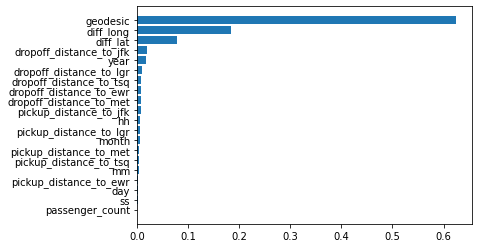

In [ ]:
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

day,ss and passenger_count features are removed from dataset and then again all models are checked for results.

# LightGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
train_data=lgbm.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=5000
cv_results = lgbm.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=200, early_stopping_rounds=20,stratified=False)
lgbm_bst=lgbm.train(param,train_data,len(cv_results['rmse-mean']))
lgbm_pred = lgbm_bst.predict(X_test)
lgbm_rmse=np.sqrt(mean_squared_error(lgbm_pred, y_test))

[200]	cv_agg's rmse: 2.99066 + 0.0214066
[400]	cv_agg's rmse: 2.92953 + 0.0212208
[600]	cv_agg's rmse: 2.90324 + 0.0217219
[800]	cv_agg's rmse: 2.88811 + 0.0219606
[1000]	cv_agg's rmse: 2.87819 + 0.0214628
[1200]	cv_agg's rmse: 2.87129 + 0.0214519
[1400]	cv_agg's rmse: 2.86582 + 0.0216142
[1600]	cv_agg's rmse: 2.86185 + 0.0215578
[1800]	cv_agg's rmse: 2.85862 + 0.0211894
[2000]	cv_agg's rmse: 2.85622 + 0.0205221
[2200]	cv_agg's rmse: 2.85407 + 0.0206498
[2400]	cv_agg's rmse: 2.85216 + 0.0208024
[2600]	cv_agg's rmse: 2.85061 + 0.0207958
[2800]	cv_agg's rmse: 2.84935 + 0.0206489
[3000]	cv_agg's rmse: 2.84798 + 0.0205919
[3200]	cv_agg's rmse: 2.84681 + 0.0207243
[3400]	cv_agg's rmse: 2.84591 + 0.0208034
[3600]	cv_agg's rmse: 2.845 + 0.0208224
[3800]	cv_agg's rmse: 2.84436 + 0.0205913


In [ ]:
print("RMSE for Light GBM is ",lgbm_rmse)

RMSE for Light GBM is  3.2958462120057233


In [ ]:
filename="/content/drive/MyDrive/NYC/Light GBM.sav"
# to save the model
pickle.dump(lgbm_bst, open(filename, 'wb'))

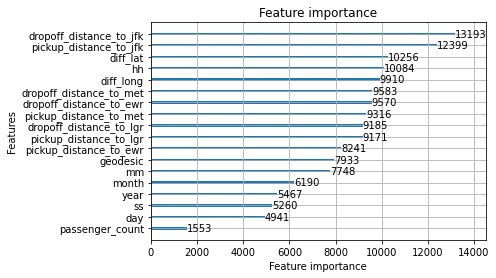

In [ ]:
lgbm.plot_importance(lgbm_bst,title='Feature importance', xlabel='Feature importance', ylabel='Features')

# XGBoost

In [ ]:
!nvidia-smi

Sun May  9 11:58:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |   2696MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
xgb_params = {
    'min_child_weight': 1, 
    'tree_method': 'gpu_hist',
    'colsample_bytree': 0.7, 
    'max_depth': 15,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

In [ ]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 1000, watchlist,early_stopping_rounds=50, maximize=False, verbose_eval=200)
    return model


In [ ]:
model = XGBmodel(X_train,X_test,y_train,y_test,xgb_params)

[0]	train-rmse:9.99741	valid-rmse:10.0185
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[32]	train-rmse:2.22434	valid-rmse:2.88754



In [ ]:
filename="/content/drive/MyDrive/NYC/XGBregressor_gpu.sav"
# to save the model
pickle.dump(model, open(filename, 'wb'))

In [ ]:
print("Done")

Done


# Deep Learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352457 entries, 10514137 to 14073333
Data columns (total 20 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   passenger_count          uint8  
 1   diff_lat                 float32
 2   diff_long                float32
 3   geodesic                 float32
 4   pickup_distance_to_jfk   float32
 5   dropoff_distance_to_jfk  float32
 6   pickup_distance_to_ewr   float32
 7   dropoff_distance_to_ewr  float32
 8   pickup_distance_to_lgr   float32
 9   dropoff_distance_to_lgr  float32
 10  pickup_distance_to_tsq   float32
 11  dropoff_distance_to_tsq  float32
 12  pickup_distance_to_met   float32
 13  dropoff_distance_to_met  float32
 14  day                      uint8  
 15  month                    uint8  
 16  year                     uint32 
 17  hh                       uint8  
 18  mm                       uint8  
 19  ss                       uint8  
dtypes: float32(13), uint32(1), uint8(6)
me

In [ ]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred


In [ ]:
H1, H2, H3 = 500, 1000, 200

In [ ]:
xx=torch.tensor(X_train.values)

In [ ]:
yy=torch.tensor(y_train.values)

In [ ]:
yy.shape

torch.Size([4353746])

In [ ]:
yy=torch.unsqueeze(yy, 1)

In [ ]:
D_in, D_out = xx.shape[1], yy.shape[1]

In [ ]:
D_out

1

In [ ]:
criterion = nn.MSELoss(reduction='sum')



In [ ]:
model1 = Net(D_in, H1, H2, H3, D_out)

In [ ]:
losses1 = []

for t in range(500):
    y_pred = model1(xx)
    
    loss = criterion(y_pred,yy)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()